In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Dataset

Dataset Original Length n:  10358
Dataset Sampled Length n:  10358


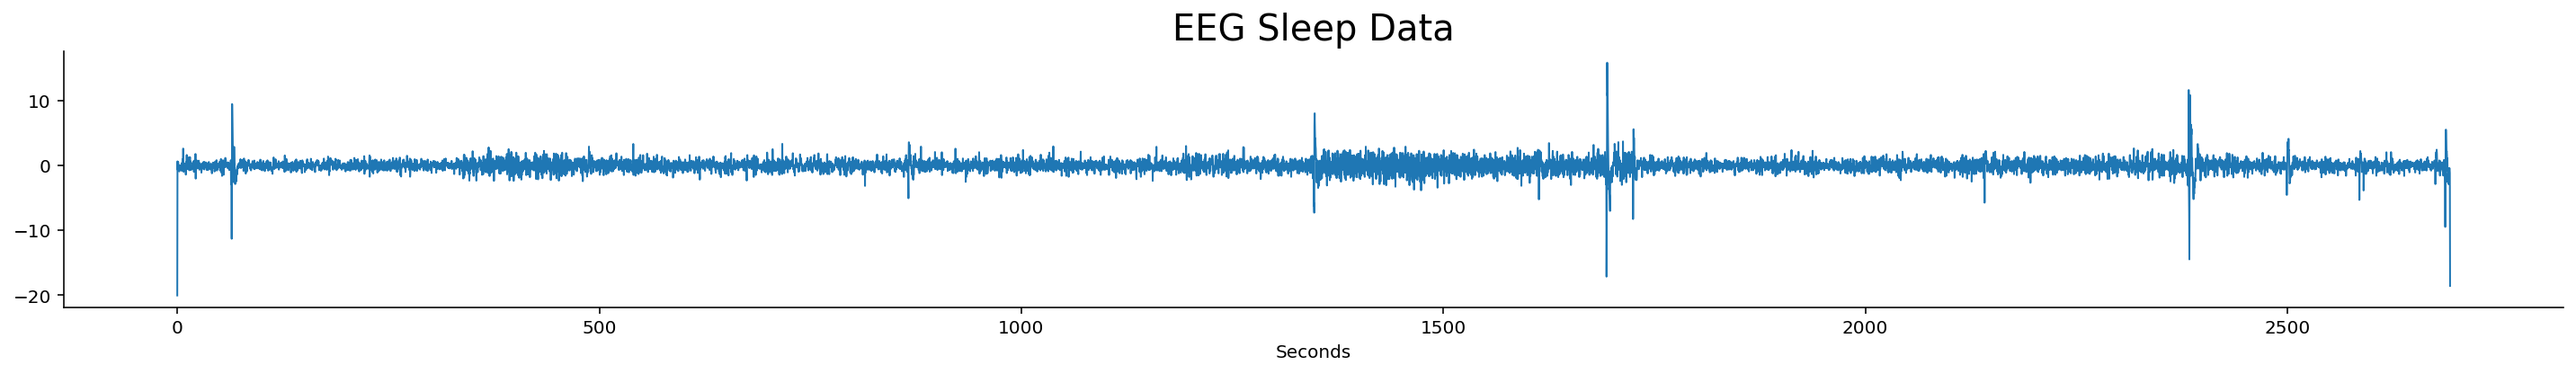

In [2]:
file = 'npo141.csv' # Dataset Length n:  269286
ds_name="EEG Sleep Data"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, 269286, 26) / 100, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [27]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
motif_length = 25
ks = 20
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv


# k-Motiflets

## We learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.10it/s]


Chosen window-size: 25
Identified Elbow Points [ 7 13 15]
Filtered Elbow Points [7, 13, 15]


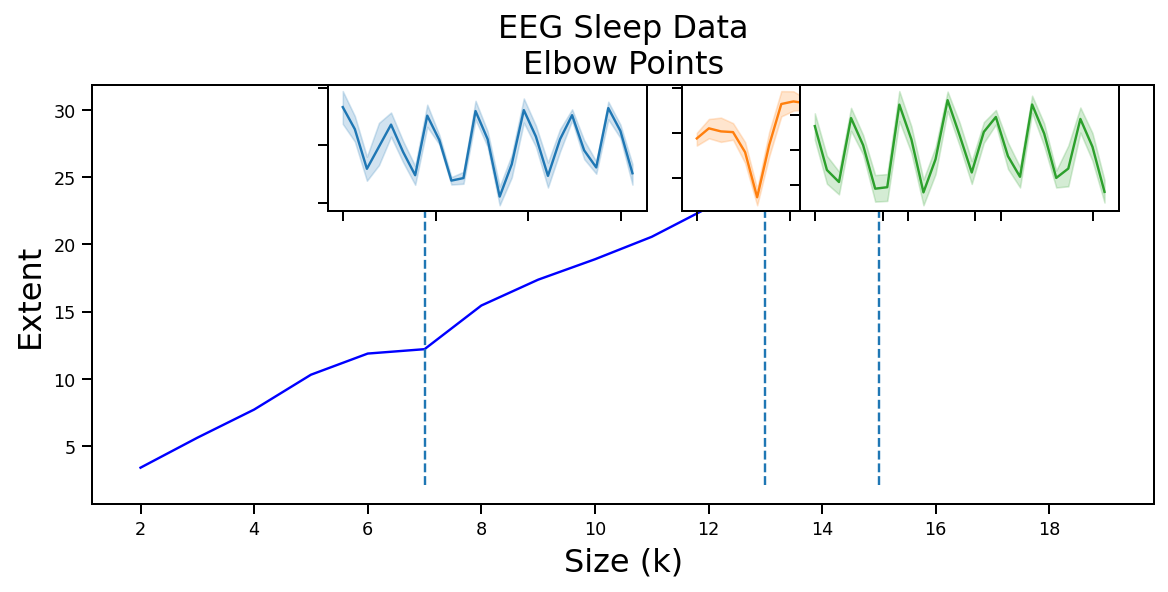

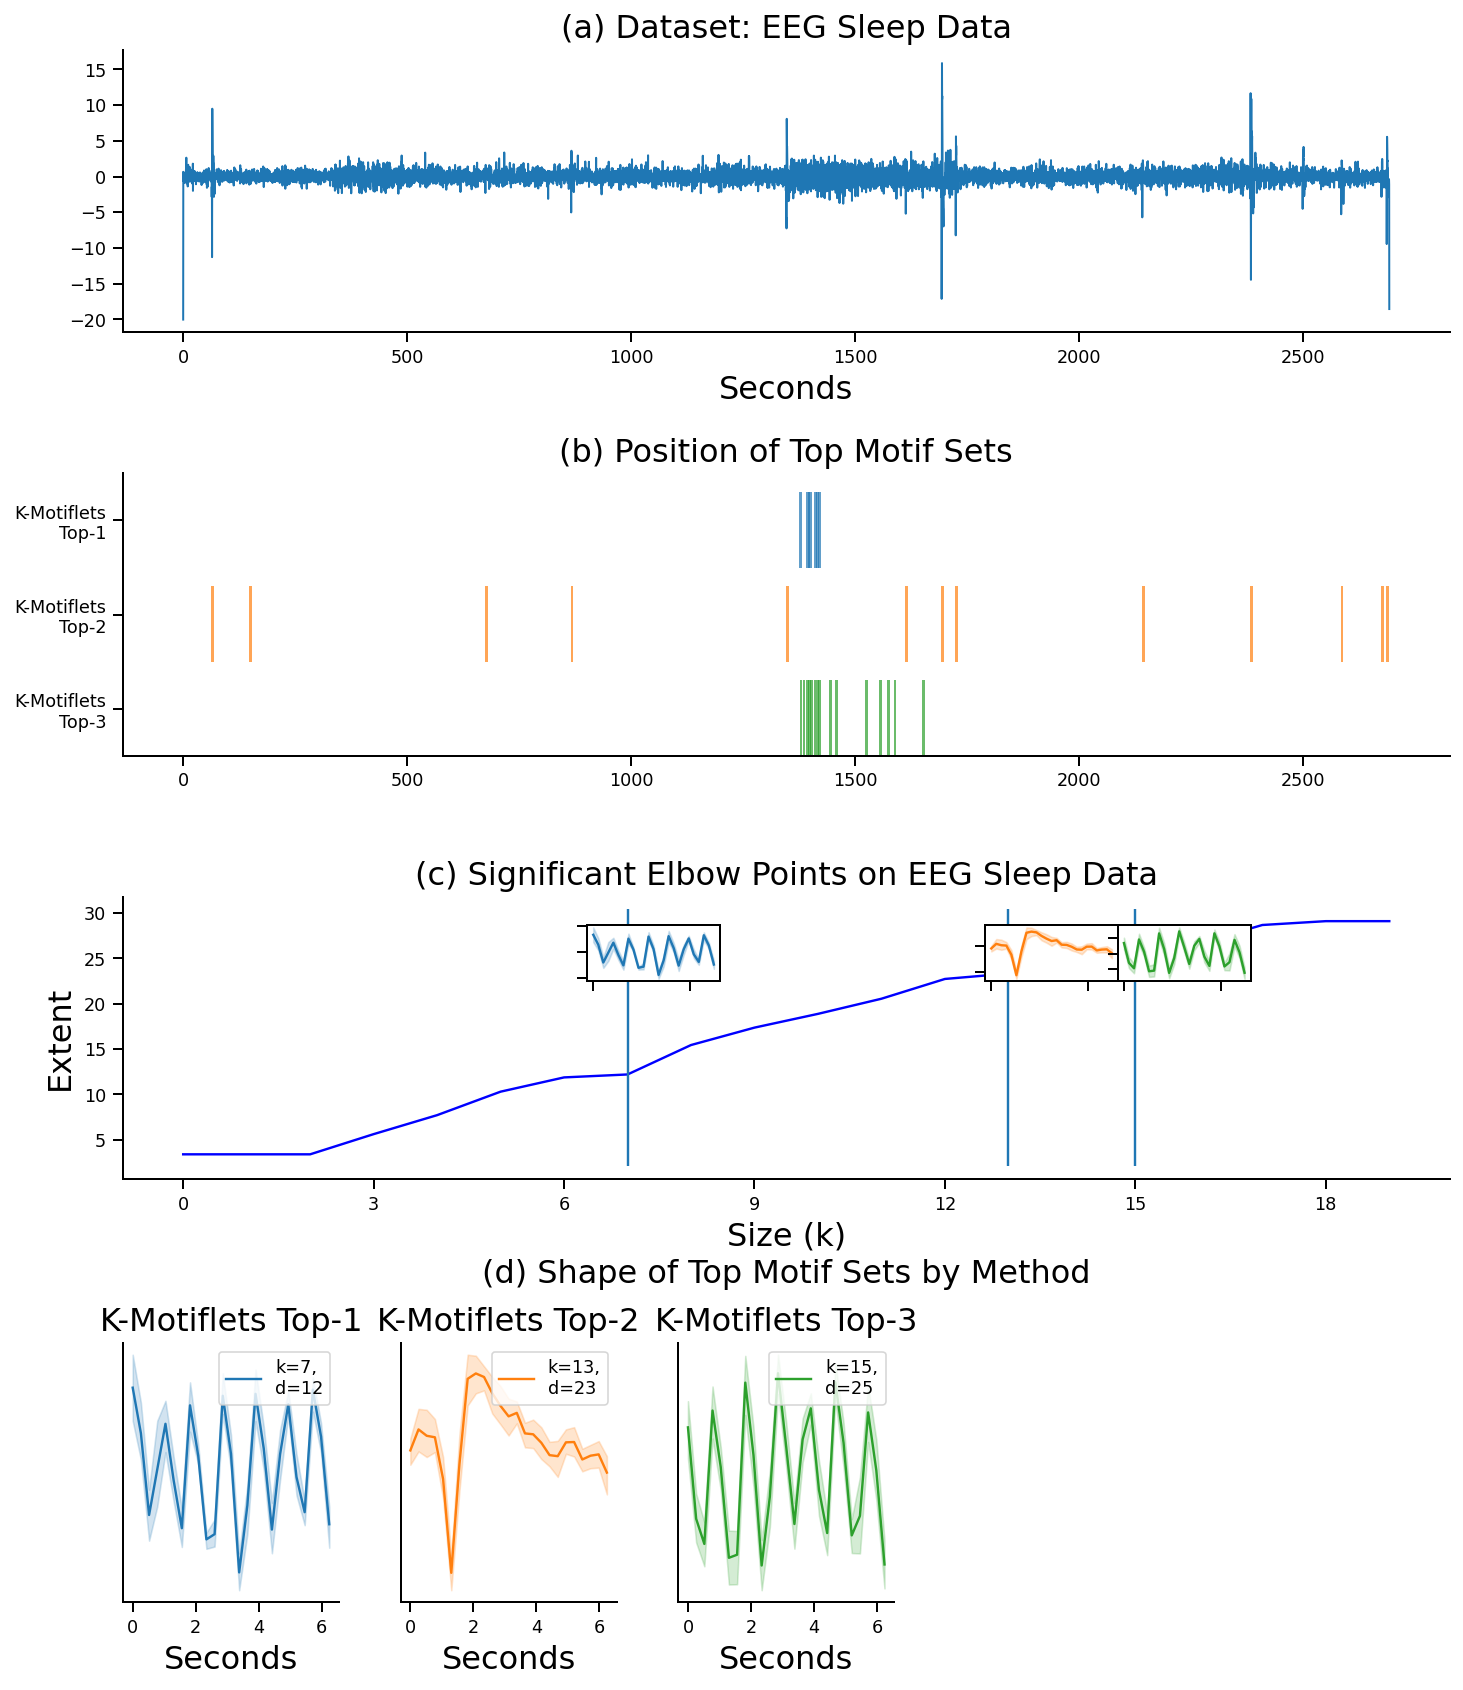

In [25]:
dists, motiflets, elbow_points = plot_elbow(
    20, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="K-Motiflets")

In [7]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 12.274670600891113 14.234710693359375
Extent d of TOP-1 Motif 25.604524612426758


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 11% on both parameters to reflect human trial-and-error.

In [26]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.11

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [14.23471069 12.2746706 ]
Best Radii	 [14.23471069 12.2746706 ]
Best Lengths	 25
Radii with human error	 [12.66889252 10.92445683]
Length with human error	 27


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [10]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

Factor:26 10357
Dataset:/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv
Set Finder
[
	[5420, 5366, 5435, 5450, 5542, 5594, 5823, 5859, 5976],
	[6493, 3311, 5160, 6614, 9593, 9924, 10270, 10314],
]


r: 15.23178482055664 d: 27.094051361083984
r: 14.649408340454102 d: 27.31999969482422


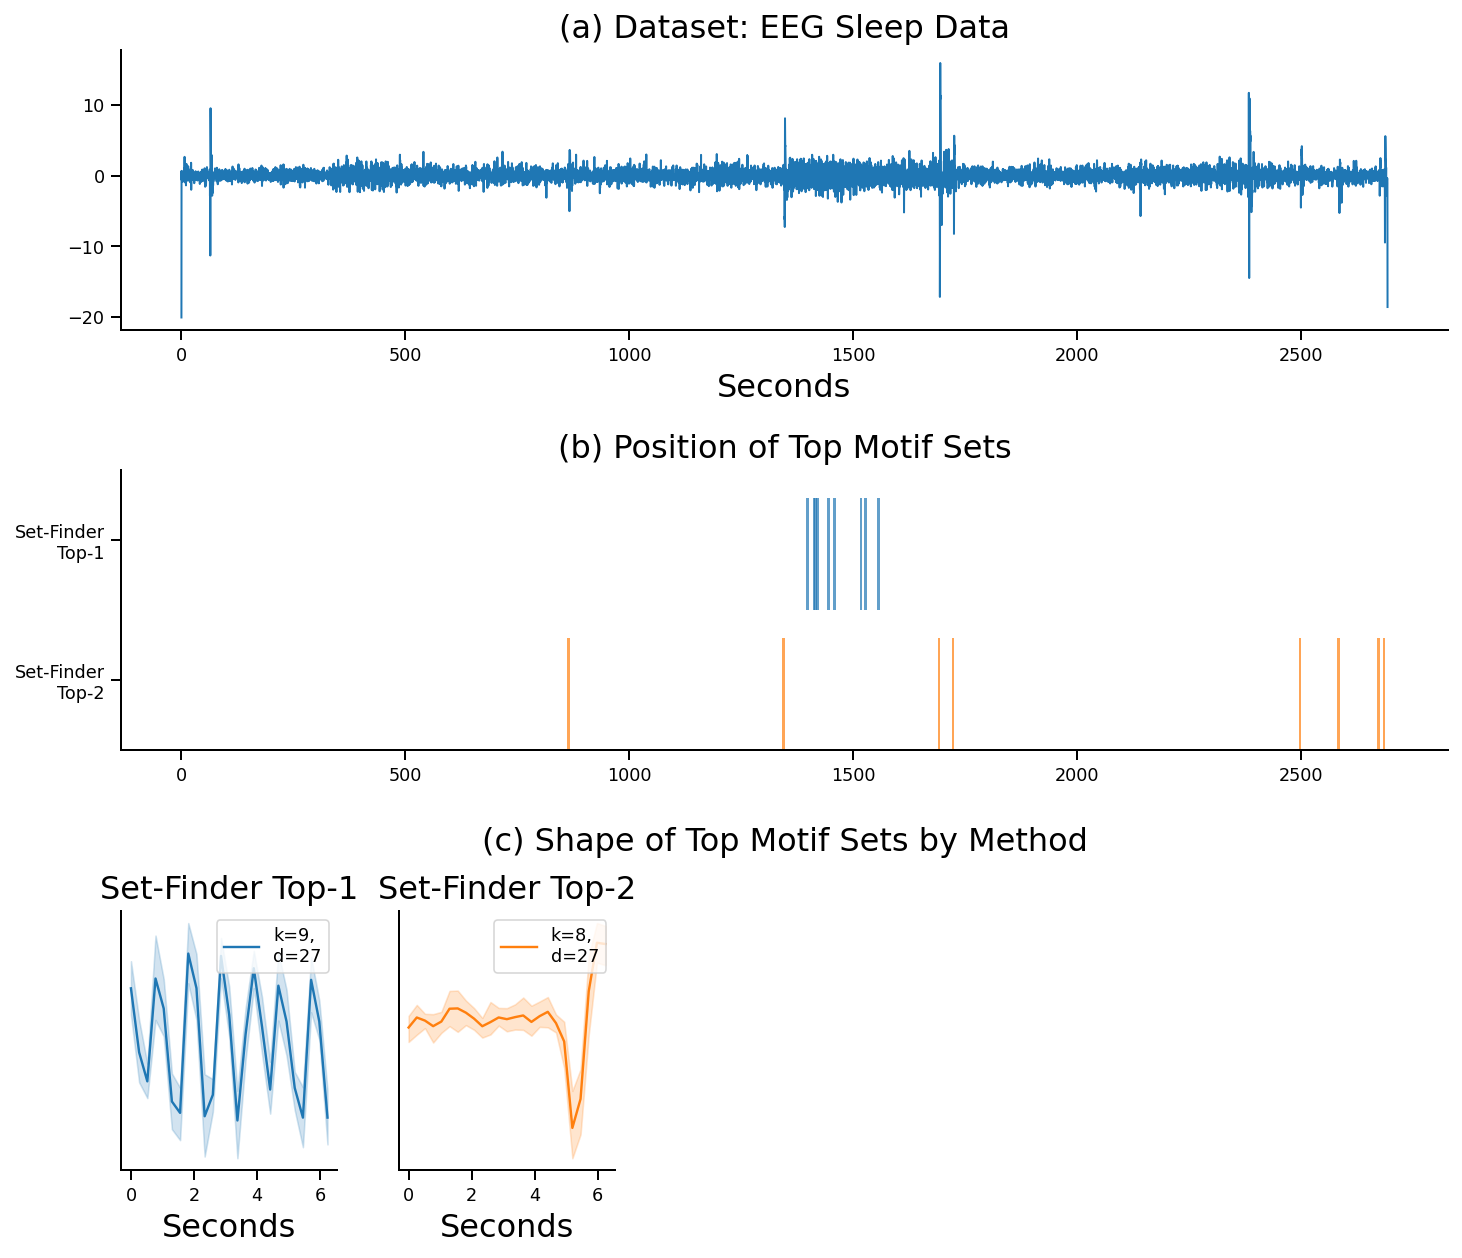

,Motiflets Top-1,Set Finder Top-1
0,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531...","[6493, 3311, 5160, 6614, 9593, 9924, 10270, 10..."


In [11]:
# run jave code first       
ms_set_finder = [
    [5420, 5366, 5435, 5450, 5542, 5594, 5823, 5859, 5976],
	[6493, 3311, 5160, 6614, 9593, 9924, 10270, 10314],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")
df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]

df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)
df

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [13]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

EMMA
Factor:26 10357
[
	[250, 5182, 6515, 9176, 9616],
	[5184, 6515, 9176, 9617],
]


r: 8.9844331741333 d: 21.231218338012695
r: 6.713440418243408 d: 12.824773788452148


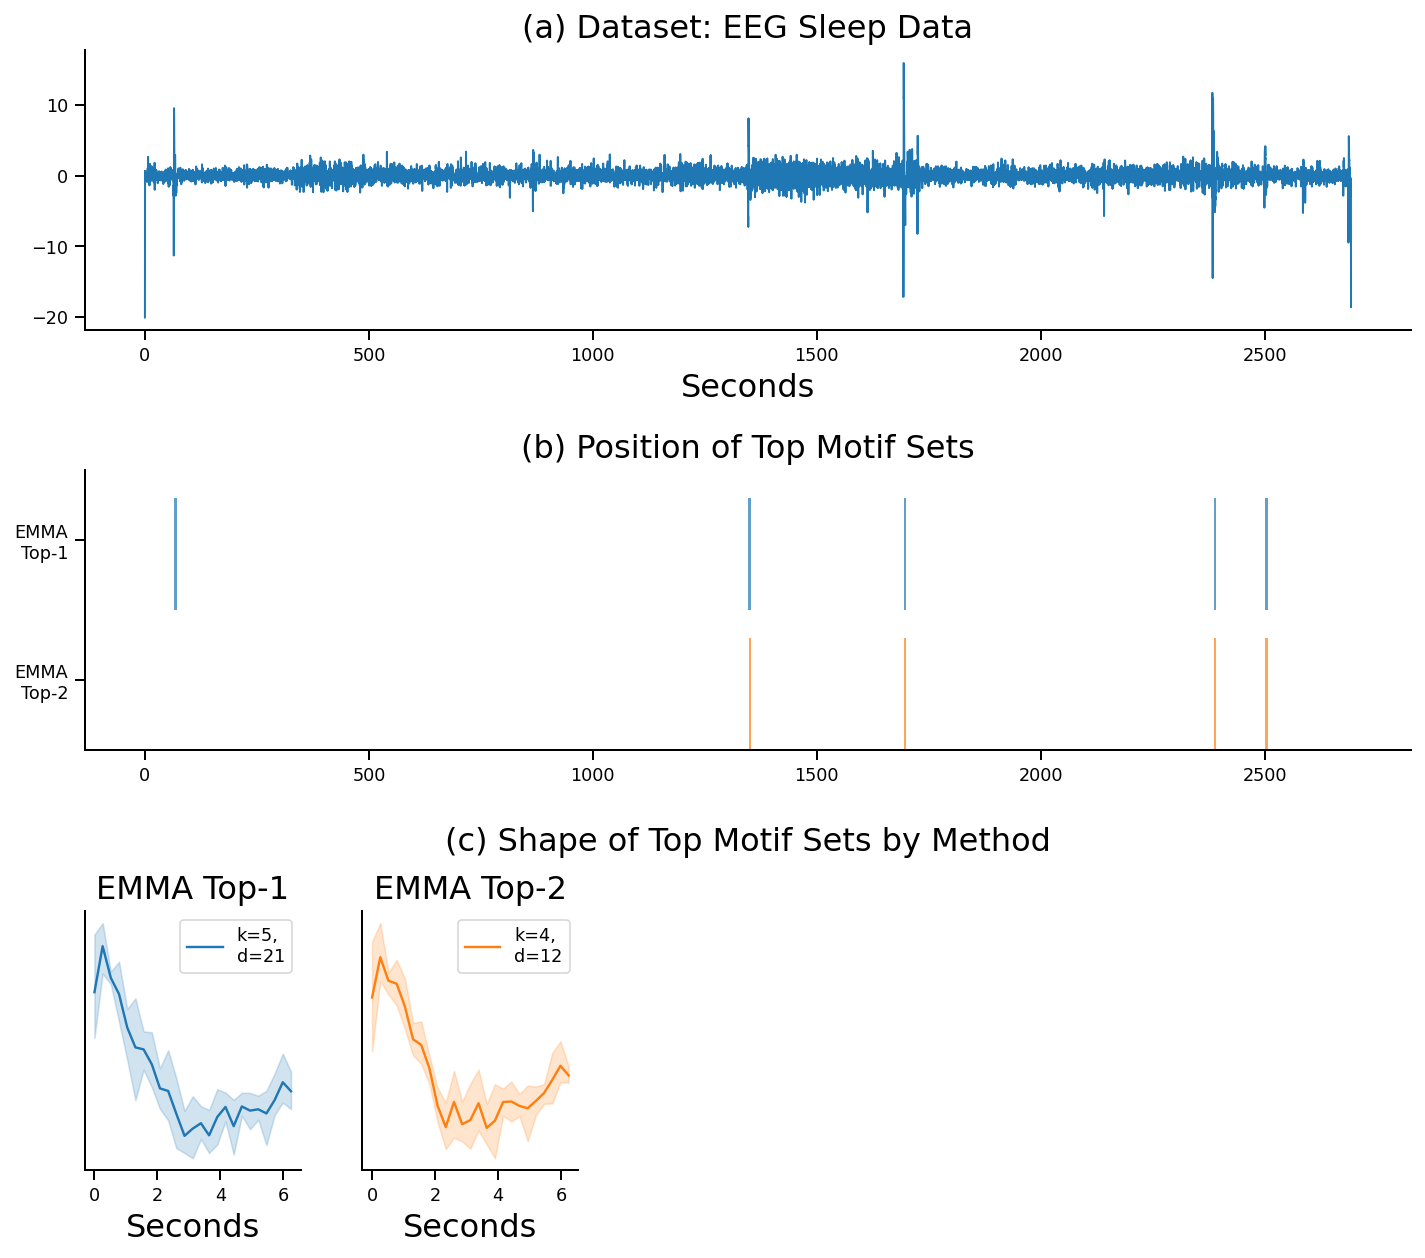

In [15]:
# run jave code first       
ms_emma = [
	[250, 5182, 6515, 9176, 9616],
	[5184, 6515, 9176, 9617],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, filter=False, prefix="EMMA")
df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 3.952667236328125 d: 3.952667236328125
r: 5.083012580871582 d: 7.033634185791016


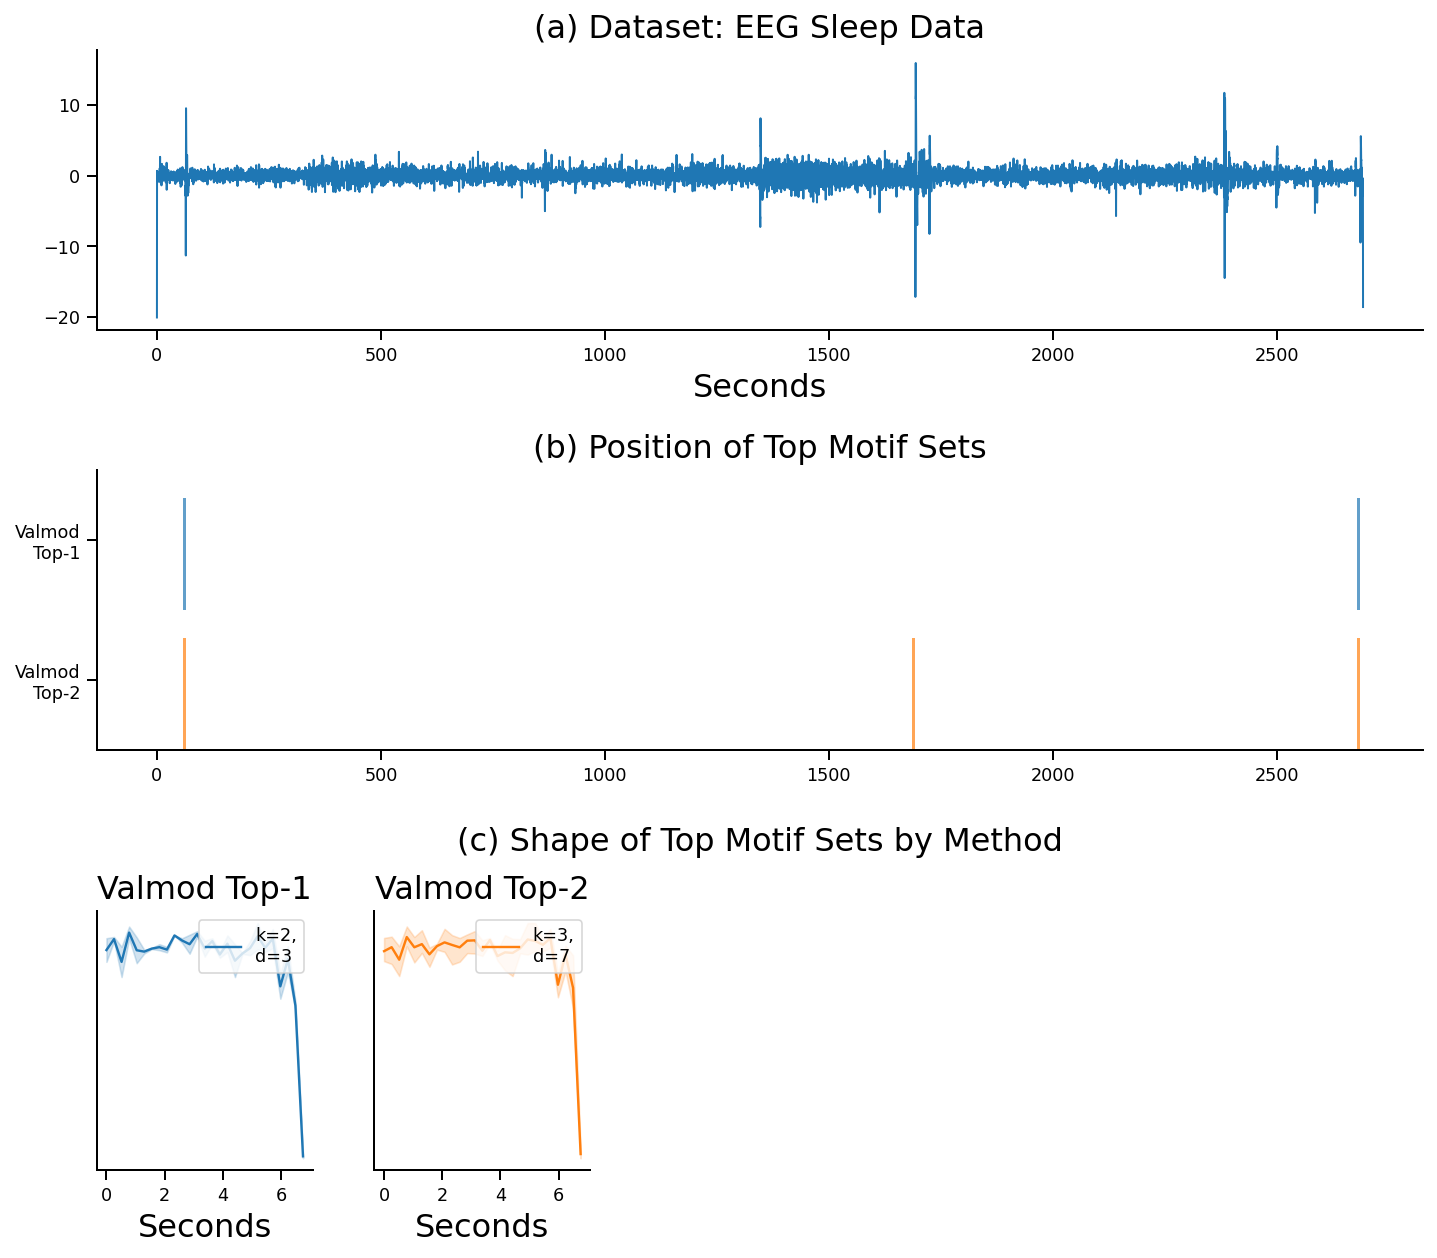

In [20]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, filter=False, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [21]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

Learning Motifs
Factor:26 10357
[
	[3804,5619,6168,],
	[242,3326,5175,6508,6628,8230,10329,],
]


r: 21.256423950195312 d: 26.691139221191406
r: 13.30839729309082 d: 23.742359161376953
Filtered Elbow Points [0, 1]


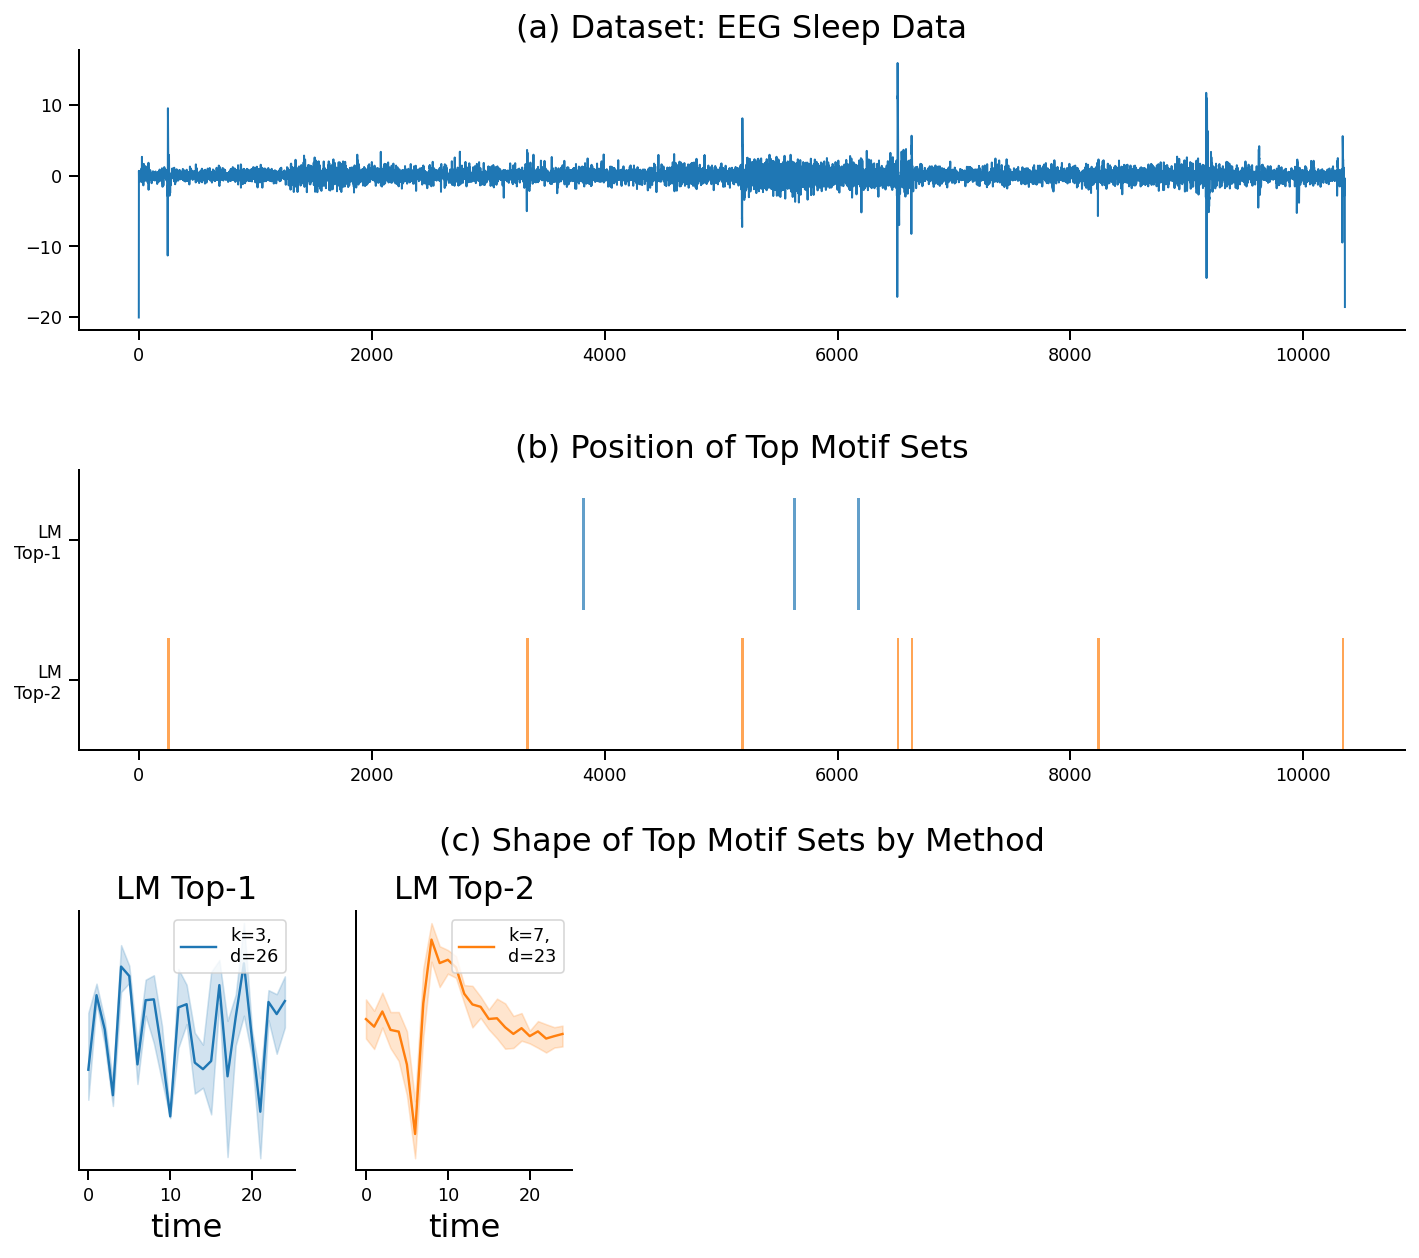

In [22]:
ms_learning_motifs = np.array([
	[3804,5619,6168,],
	[242,3326,5175,6508,6628,8230,10329,],
])
    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, 
                            motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [23]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531..."
Set Finder Top-1,"[6493, 3311, 5160, 6614, 9593, 9924, 10270, 10..."
EMMA Top-1,"[5184, 6515, 9176, 9617]"
VALMOD Top-1,"[222, 6487, 10309]"
LM Top-1,"[242, 3326, 5175, 6508, 6628, 8230, 10329]"
Motiflets Top-2,"[6629, 10330, 6508, 243, 10285, 6200, 8231, 56..."
Set Finder Top-2,"[5420, 5366, 5435, 5450, 5542, 5594, 5823, 585..."
EMMA Top-2,"[250, 5182, 6515, 9176, 9616]"
VALMOD Top-2,"[222, 10309]"
LM Top-2,"[3804, 5619, 6168]"


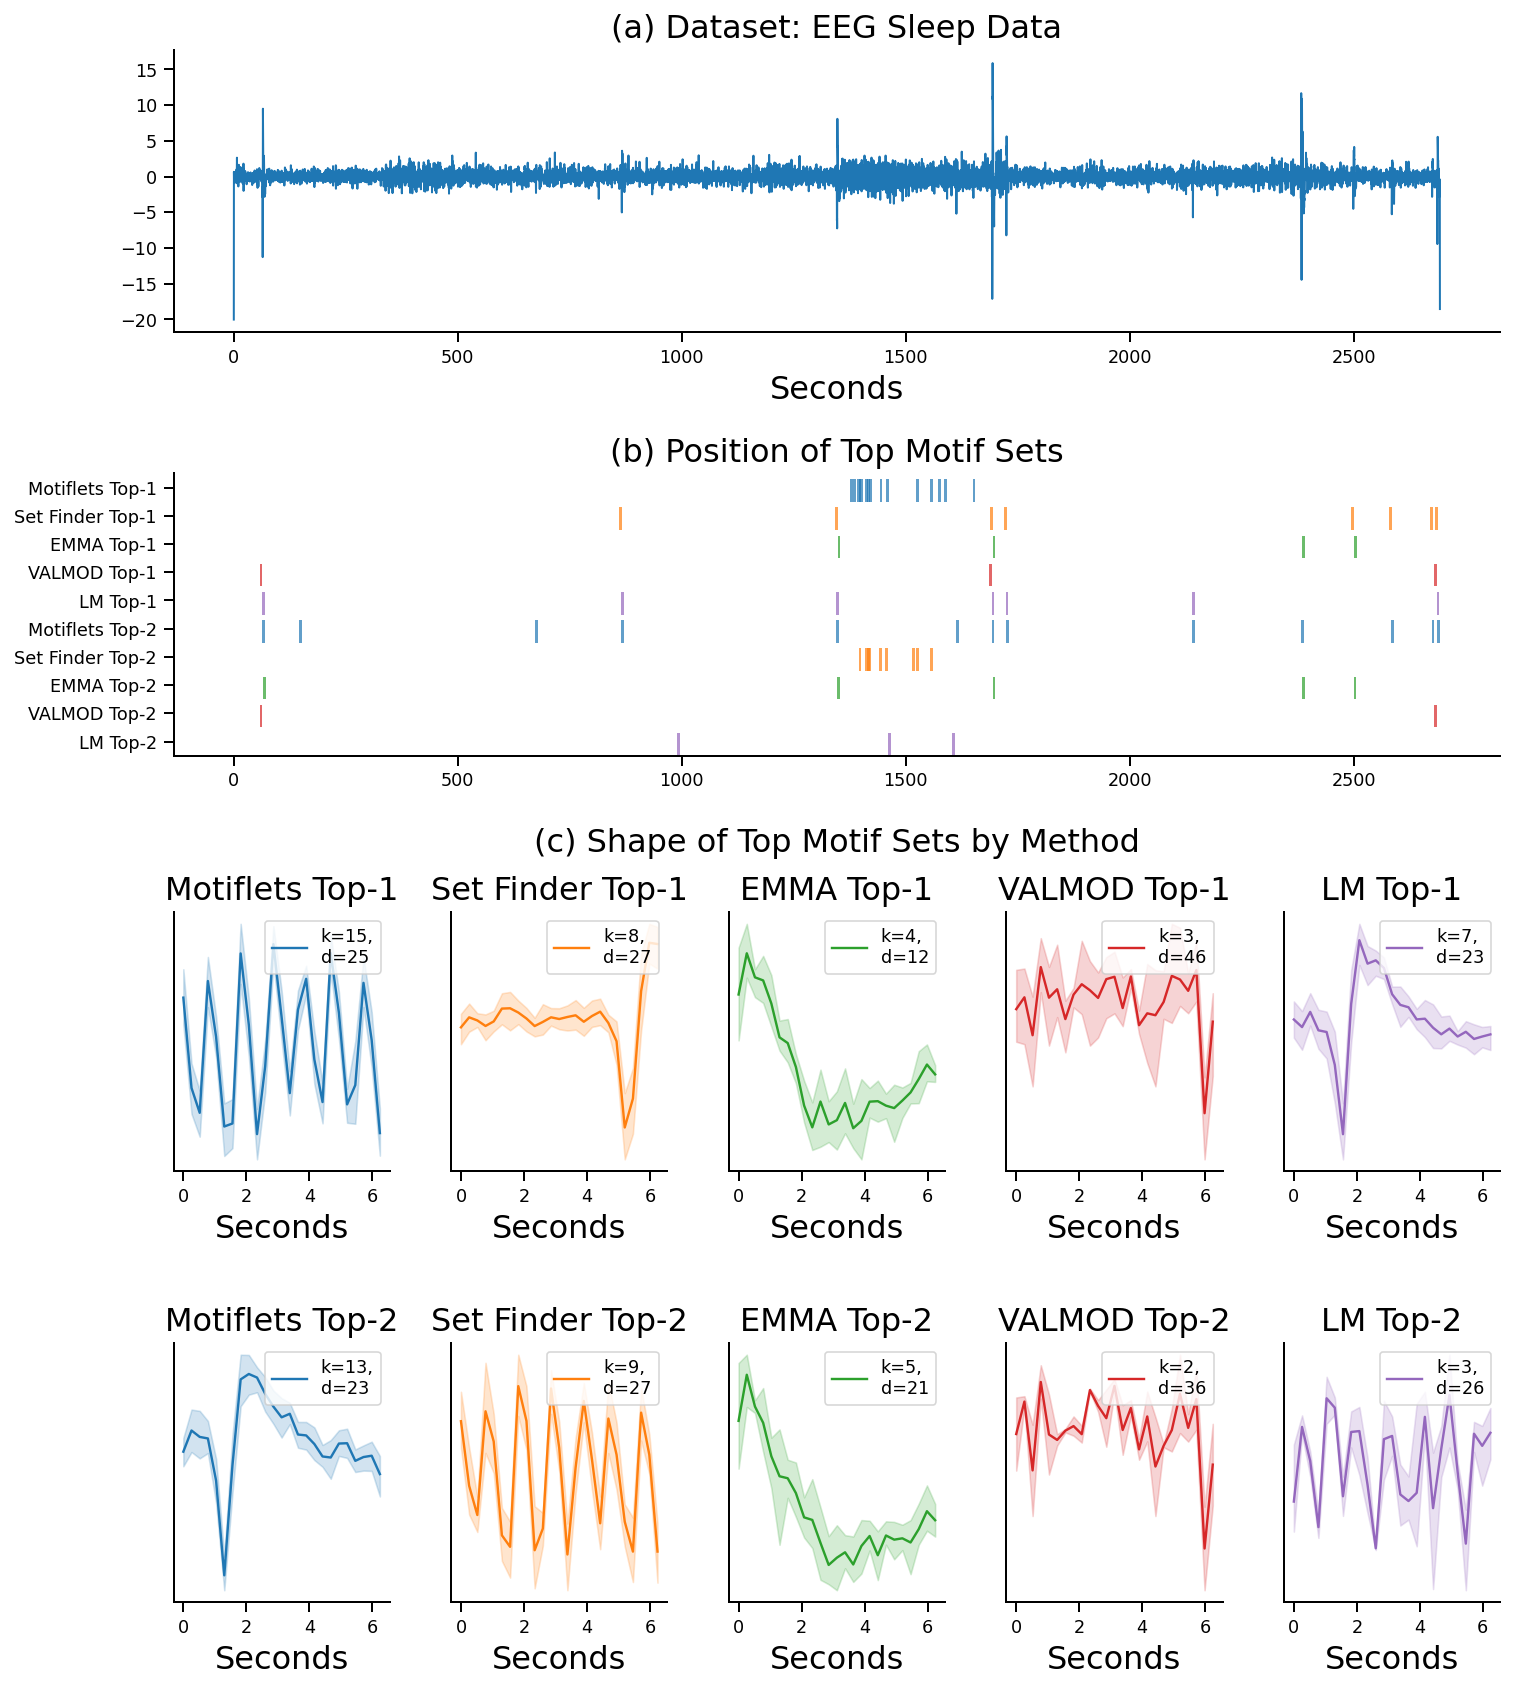

In [28]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)